In [1]:
# coding: utf-8
import os
import numpy as np
import json
import nltk
os.chdir("/home/idea/PycharmProjects/kbqa/")


In [40]:
def extract_glove(path):
    words_list = []
    words_list.append("padding_")
    words_list.append("unk_")
    index = 2
    vector_writer = open("vocab/glove_vector.txt", "w")
    zero_vector = " ".join([str(0.) for x in range(300)])
    vector_writer.write(zero_vector+'\n')
    vector_writer.write(zero_vector+'\n')
    with open(path, 'r') as f:
        for line in f:
            vals = line.split(' ')
            word = vals[0]
            words_list.append(word)
            vector = vals[1:]
            index += 1
            vector_writer.write(" ".join(vector))
    print("words　list")
    json_word_list = json.dumps(words_list)
    with open('vocab/vocab.pt', 'w') as w:
        w.write(json_word_list)
    print("word list have saved!")
extract_glove("vocab/glove.42B.300d.txt")
print("extract glove done!")

words　list


word list have saved!


extract glove done!


In [4]:
import sys
sys.path.append('tool/')
import virtuoso

# 加载有entity name的所有实体
entities_set = set(json.load(open('data/entities.pt','r')))
print("{} entities have name.".format(len(entities_set)))
count = 0
'''
for subid in entities_set:
    names1 = virtuoso.id_query_name("fb:"+subid)
    names2 = virtuoso.id_query_en_alias("fb:"+subid)
    names1.extend(names2)
    if len(names1) > 0:
        count += 1
print("count:{}".format(count))
# words = virtuoso.id_query_name("fb:"+ent_id)
'''

3972548 entities have name.


'\nfor subid in entities_set:\n    names1 = virtuoso.id_query_name("fb:"+subid)\n    names2 = virtuoso.id_query_en_alias("fb:"+subid)\n    names1.extend(names2)\n    if len(names1) > 0:\n        count += 1\nprint("count:{}".format(count))\n# words = virtuoso.id_query_name("fb:"+ent_id)\n'

training set:


max sentence len:36
max word len:64
word longest:unedcgitkcrvubfhtfridcjvrbgkglhijcfjeniefukckbrtgggdfjftetutrubb


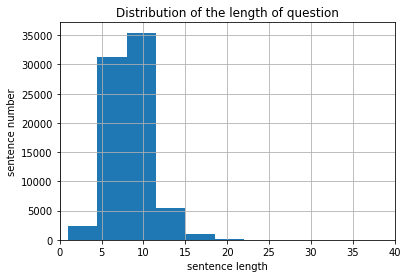

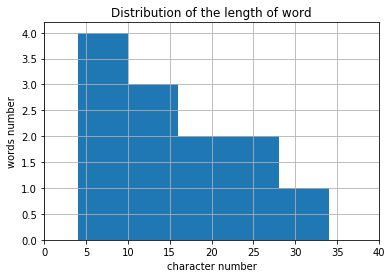

test set:


max sentence len:26
max word len:50
word longest://our.intern.facebook.com/intern/freebase/question


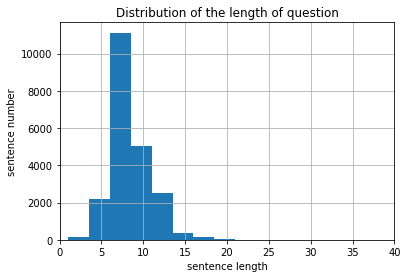

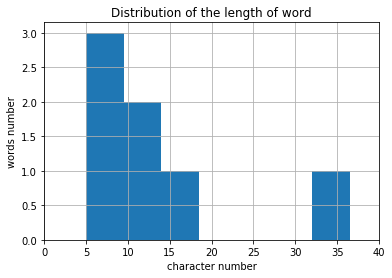

validation set:


max sentence len:21
max word len:48
word longest:brompheniramine/pseudoephedrine/dextromethorphan


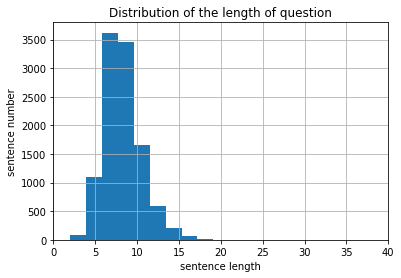

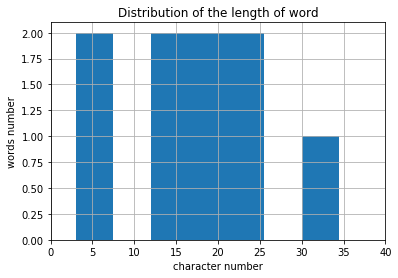

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# split words of relation
def extract_rel(rel):
    rel_words = []
    vals = rel.lower().split("/")
    for v in vals:
        rel_words.extend(v.split("_"))
    return rel_words

# record all characters
chars = set()
# extract subject, relation, object and relation from data set.
def extract_dataset(path, viewable_path):
    max_sentence_len = 0
    max_word_len = 0
    word_longest = ''
    len_sentence_list = []
    len_word_list = []
    writer = open(viewable_path, 'w', encoding='utf-8')
    with open(path,'r', encoding='utf-8') as f:
        for line in f:
            vals = line.strip().lower().split("\t")
            sub = "m." + vals[0].split("/")[-1]
            if sub not in entities_set:
                continue
            rel = vals[1].replace("www.freebase.com/", "")
            obj = vals[2].split("/")[-1]
            qu = vals[3].replace("\\", " ")
            words = nltk.word_tokenize(qu)
            sentence_len = len(words)
            len_sentence_list.append(sentence_len)
            sub_name = virtuoso.id_query_name("fb:"+sub)
            sub_alias = virtuoso.id_query_alias("fb:"+sub)
            sub_name.extend(sub_alias)
            if len(sub_name) == 0:
                print(sub)
            # all chars of subject's names
            for name in sub_name:
                for c in name.lower():
                    chars.add(c)
            rel_words = extract_rel(rel)
            # all chars of relation words
            for word in rel_words:
                for c in word:
                    chars.add(c)
            # all char of question words
            for word in words:
                for c in word:
                    chars.add(c)
            writer.write(sub+"\t||\t"+sub_name[0].lower()+"\t||\t"+" ".join(rel_words)+"\t||\t"+" ".join(words)+"\n")
            if max_sentence_len < sentence_len:
                max_sentence_len = sentence_len
            for word in words:
                word_len = len(word)
                if max_word_len < word_len:
                    max_word_len = word_len
                    word_longest = word
                    len_word_list.append(word_len)
    writer.close()
    print("max sentence len:{}".format(max_sentence_len))
    print("max word len:{}".format(max_word_len))
    print("word longest:{}".format(word_longest))
    sentence_data = pd.DataFrame({'sentence_length':len_sentence_list}, index=range(len(len_sentence_list)))
    sentence_data['sentence_length'].hist(bins=10)
    plt.xlim(0,40)
    plt.xlabel("sentence length")
    plt.ylabel("sentence number")
    plt.title("Distribution of the length of question")
    plt.show()
    word_data = pd.DataFrame({'word_length':len_word_list}, index=range(len(len_word_list)))
    word_data['word_length'].hist(bins=10)
    plt.xlim(0,40)
    plt.xlabel("character number")
    plt.ylabel("words number")
    plt.title("Distribution of the length of word")
    plt.show()
# extract training data
print("training set:")
extract_dataset("data/SimpleQuestions/annotated_fb_data_train.txt","data/train/source/train.txt")
print("test set:")
extract_dataset("data/SimpleQuestions/annotated_fb_data_test.txt","data/test/source/test.txt")
print("validation set:")
extract_dataset("data/SimpleQuestions/annotated_fb_data_valid.txt","data/valid/source/valid.txt")

In [29]:
print("there is {} characters.".format(len(chars)))
chars_list = ['padding_', 'unk_']
chars_list.extend(sorted(chars))
char_dumps = json.dumps(chars_list)
print("there is {} characters.".format(len(chars_list)))
with open("data/char_dict.pt", 'w') as w:
    w.write(char_dumps)
print("char dictionary has been saved!")

there is 1765 characters.
there is 1767 characters.
char dictionary has been saved!


In [76]:
# generate relation set
relations = set()
with open('data/freebase-subsets/freebase-FB2M.txt', 'r') as reader:
    for line in reader:
        cur_rel = line.split("\t")[1].replace("www.freebase.com/", "")
        relations.add(cur_rel)
print("In FB2M, there is {} relations.".format(len(relations)))
rel_list = sorted(relations)
with open("data/relations.txt", "w") as file:
    for r in rel_list:
        file.write(r + "\n")
with open("data/rel_list.pt", "w") as file:
    json_rels = json.dumps(rel_list)
    file.write(json_rels)
print("relation.txt and rel_list.pt have been saved!")

rel_words_list = []
for r in rel_list:
    rel_words_list.append(" ".join(extract_rel(r)))
with open("data/wordsrel_list.pt", "w") as file:
    file.write(json.dumps(rel_words_list))
print("words relation have been saved!")

In FB2M, there is 6701 relations.
relation.txt and rel_list.pt have been saved!
words relation have been saved!


In [40]:
print("check entities in FB2M")
entities_fb2m = set()
with open("data/freebase-subsets/freebase-FB2M.txt", "r") as reader:
    for line in reader:
        cur_entid = "m." + line.split("\t")[0].replace("www.freebase.com/m/", "")
        entities_fb2m.add(cur_entid)
print("In FB2M, there is {} subject.".format(len(entities_fb2m)))
ent_fb2m_named = entities_fb2m & entities_set
print("{} entities have names.".format(len(ent_fb2m_named)))

check entities in FB2M


In FB2M, there is 1959820 subject.
1952127 entities have names.


In [46]:
# save FB2M entities

entities_fb2m = sorted(entities_fb2m)
with open("data/fb2m_ent.pt", "w") as f:
    f.write(json.dumps(entities_fb2m))
print("FB2M entities have been saved!")

FB2M entities have been saved!


max subject name length:452


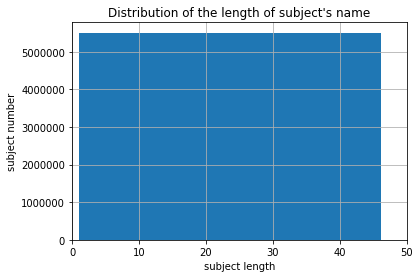

In [8]:
#　analyse sub name by words
import re
import pandas as pd
import matplotlib.pyplot as plt

max_sub_len = 0
sub_len_list= []
with open("data/datainfo/FB.name.txt", "r") as f:
    for line in f:
        vals = line.split("\t")
        try:
            name = re.findall('"(.*)"', vals[2])[0]
        except:
            print(line)
            break
        cur_len = len(name.split(" "))
        if max_sub_len < cur_len:
            max_sub_len = cur_len
        sub_len_list.append(cur_len)
print("max subject name length:{}".format(max_sub_len))
sub_data = pd.DataFrame({"subject_len":sub_len_list}, index=[x for x in range(len(sub_len_list))])
sub_data['subject_len'].hist(bins=10)
plt.xlim(0,50)
plt.xlabel("subject length")
plt.ylabel("subject number")
plt.title("Distribution of the length of subject's name")
plt.show()


In [33]:
# load vocab list

vocab＿list = json.load(open('vocab/vocab.pt', 'r'))
print(type(vocab＿list))
print(vocab＿list.index('word'))

# load relation words
rel_words_list = json.load(open('data/wordsrel_list.pt', 'r'))

# load fb2m entities

entities_fb2m = json.load(open('data/fb2m_ent.pt', 'r'))

<class 'list'>
695


In [2]:
# load char dict
chars_list = json.load(open('data/char_dict.pt', 'r'))
print(type(chars_list))
print("there are {} characters.".format(len(chars_list)))

<class 'list'>
there are 1767 characters.


relation analysis
relation numbers:6701
relation max length:17


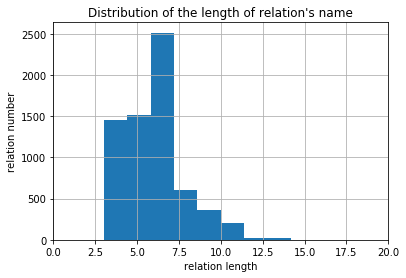

In [17]:
# analyse relation
print("relation analysis")
print("relation numbers:{}".format(len(rel_words_list)))
max_rel_len = 0
rel_lens = []
for rel_words in rel_words_list:
    cur_len = len(rel_words.split(" "))
    rel_lens.append(cur_len)
    if cur_len > max_rel_len:
        max_rel_len = cur_len
print("relation max length:{}".format(max_rel_len))
rel_data = pd.DataFrame({"rel_len":rel_lens}, index=[x for x in range(len(rel_words_list))])
rel_data['rel_len'].hist(bins=10)
plt.xlim(0,20)
plt.xlabel("relation length")
plt.ylabel("relation number")
plt.title("Distribution of the length of relation's name")
plt.show()

In [40]:
# generate training data example
w_index_dict = dict((vocab＿list[i], str(i)) for i in range(len(vocab＿list)))
c_index_dict = dict((chars_list[i], str(i)) for i in range(len(chars_list)))

n_neg = 5
n_pos = 1
max＿qu_len = 24
max_sub_len = 36
max_word＿len = 35

# entities and relations counts
ent_n = len(entities_fb2m)
rel_n = len(rel_words_list)

def generate_indexseq(seq):
    len_list = []
    words = seq.split(" ")
    seq_len = len(words)
    len_list.append(str(seq_len))
    index_words = ['1' if w_index_dict.get(w) is None else w_index_dict.get(w) for w in words]
    if seq_len > max＿qu_len:
        index_words = index_words[0:max＿qu_len]
    elif seq_len < max＿qu_len:
        for i in range(max＿qu_len - seq_len):
            index_words.append('0')
    index_chars_list = []
    count = 0
    for word in words:
        w_len = len(word)
        len_list.append(str(w_len))
        index_c = ['1' if c_index_dict.get(c) is None else c_index_dict.get(c) for c in word]
        if w_len > max_word＿len:
            index_c = index_c[0:max_word＿len]
        elif w_len < max_word＿len:
            for i in range(max_word＿len - w_len):
                index_c.append('0')
        index_chars_list.extend(index_c)
        count += 1
        if count == max＿qu_len:
            break
    '''
    if count < max＿qu_len:
        index_chars_list.append([0 for x in range((max＿qu_len - count)*max_word＿len)])
    '''
    return index_words, index_chars_list, len_list

# 
import sys
sys.path.append('tool/')
import virtuoso


def query_subname(id):
    name = virtuoso.id_query_name("fb:"+id)
    if len(name) != 0:
        return name[0]
    else:
        try:
            name = virtuoso.id_query_alias("fb:"+id)
            return name[0]
        except:
            return ""

max_rel_len = 17

def generate_rel_indexseq(seq):
    len_list = []
    words = seq.split(" ")
    seq_len = len(words)
    len_list.append(str(seq_len))
    index_words = ['1' if w_index_dict.get(w) is None else w_index_dict.get(w) for w in words]
    if seq_len > max_rel_len:
        index_words = index_words[0:max_rel_len]
    elif seq_len < max_rel_len:
        for i in range(max_rel_len - seq_len):
            index_words.append('0')
    return index_words, len_list

def get＿negsub(golden, all_list, max_n):
    randid = np.random.randint(0,max_n)
    while True:
        cur_sub = all_list[randid]
        if  cur_sub != golden:
            return cur_sub
        else:
            randid = np.random.randint(0,max_n)


def get_negrel(golden, max_n):
    pass

def getneg(golden, all_list, max_n):
    randid = np.random.randint(0,max_n)
    while True:
        cur_sub = all_list[randid]
        if  cur_sub != golden:
            return cur_sub
        else:
            randid = np.random.randint(0,max_n)

def generate(source, qupath, qucpath, qulenpath, subpath, subcpath, sublenpath, relpath, rellenpath, labelpath):
    qu_wr = open(qupath, 'w')
    quc_wr = open(qucpath, 'w')
    qulen_wr = open(qulenpath, 'w')
    sub_wr = open(subpath, 'w')
    subc_wr = open(subcpath, 'w')
    sublen_wr = open(sublenpath, 'w')
    rel_wr = open(relpath, 'w')
    rellen_wr = open(rellenpath, 'w')
    label_wr = open(labelpath, 'w')
    with open(source, 'r', encoding='utf-8') as f:
        for line in f:
            vals = line.strip().split("\t||\t")
            golden_id = vals[0]
            golden_name = vals[1]
            golden_rel = vals[2]
            qu = vals[3]
            sub_seq, sub_c_seq, sub_lens = generate_indexseq(golden_name)
            qu_seq, qu_c_seq, qu_lens = generate_indexseq(qu)
            rel_seq, rel_lens = generate_rel_indexseq(golden_rel)
            # question
            qu_wr.write(" ".join(qu_seq)+"\n")
            quc_wr.write(" ".join(qu_c_seq)+"\n")
            qulen_wr.write(" ".join(qu_lens)+"\n")
            # subject
            sub_wr.write(" ".join(sub_seq)+"\n")
            subc_wr.write(" ".join(sub_c_seq)+"\n")
            sublen_wr.write(" ".join(sub_lens)+"\n")
            # relation
            rel_wr.write(" ".join(rel_seq)+"\n")
            rellen_wr.write(" ".join(rel_lens)+"\n")
            label_wr.write("1"+"\n")
            for i in range(n_neg):
                neg_subid = getneg(golden_id, entities_fb2m, ent_n)
                neg_sub_name = query_subname(neg_subid)
                neg_rel = getneg(golden_rel, rel_words_list, rel_n)
                sub_seq, sub_c_seq, sub_lens = generate_indexseq(neg_sub_name)
                rel_seq, rel_lens = generate_rel_indexseq(neg_rel)
                # question
                qu_wr.write(" ".join(qu_seq)+"\n")
                quc_wr.write(" ".join(qu_c_seq)+"\n")
                qulen_wr.write(" ".join(qu_lens)+"\n")
                # subject
                sub_wr.write(" ".join(sub_seq)+"\n")
                subc_wr.write(" ".join(sub_c_seq)+"\n")
                sublen_wr.write(" ".join(sub_lens)+"\n")
                # relation
                rel_wr.write(" ".join(rel_seq)+"\n")
                rellen_wr.write(" ".join(rel_lens)+"\n")
                label_wr.write("0"+"\n")
    qu_wr.close()
    quc_wr.close()
    qulen_wr.close()
    sub_wr.close()
    subc_wr.close()
    sublen_wr.close()
    rel_wr.close()
    rellen_wr.close()
    label_wr.close()

generate("data/train/source/train.txt",
         "data/train/qu.txt",
         "data/train/quc.txt",
         "data/train/qulen.txt",
         "data/train/sub.txt",
         "data/train/subc.txt",
         "data/train/sublen.txt",
         "data/train/rel.txt",
         "data/train/rellen.txt",
         "data/train/label.txt")

In [41]:
generate("data/test/source/test.txt",
         "data/test/qu.txt",
         "data/test/quc.txt",
         "data/test/qulen.txt",
         "data/test/sub.txt",
         "data/test/subc.txt",
         "data/test/sublen.txt",
         "data/test/rel.txt",
         "data/test/rellen.txt",
         "data/test/label.txt")
print("test done！")

generate("data/valid/source/valid.txt",
         "data/valid/qu.txt",
         "data/valid/quc.txt",
         "data/valid/qulen.txt",
         "data/valid/sub.txt",
         "data/valid/subc.txt",
         "data/valid/sublen.txt",
         "data/valid/rel.txt",
         "data/valid/rellen.txt",
         "data/valid/label.txt")
print("valid done！")

test done！


valid done！


max subject name length:3055


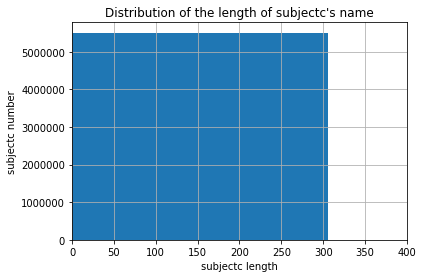

In [6]:
#　analyse sub name by characters
import re
import pandas as pd
import matplotlib.pyplot as plt

max_subc_len = 0
subc_len_list= []
with open("data/datainfo/FB.name.txt", "r") as f:
    for line in f:
        vals = line.split("\t")
        try:
            name = re.findall('"(.*)"', vals[2])[0]
        except:
            print(line)
            break
        cur_len = len(name)
        if max_subc_len < cur_len:
            max_subc_len = cur_len
        subc_len_list.append(cur_len)
print("max subject name length:{}".format(max_subc_len))
sub_data = pd.DataFrame({"subjectc_len":subc_len_list}, index=[x for x in range(len(subc_len_list))])
sub_data['subjectc_len'].hist(bins=10)
plt.xlim(0,400)
plt.xlabel("subjectc length")
plt.ylabel("subjectc number")
plt.title("Distribution of the length of subjectc's name")
plt.show()

In [11]:
# build entity-name dict and save it
import pickle
import json
import re

entities_fb2m = json.load(open('data/fb2m_ent.pt', 'r'))
entities_fb2m = set(entities_fb2m)
id_name_dict = dict()
with open("data/datainfo/FB.name.txt", "r") as f:
    for line in f:
        vals = line.split("\t")
        id = re.findall('<fb:(.*)>', vals[0])[0]
        name = re.findall('"(.*)"', vals[2])[0]
        if id not in entities_fb2m or name == '':
            continue
        if id_name_dict.get(id) is None:
            id_name_dict[id] = [name.lower()]
        else:
            id_name_dict[id].append(name)
    print("done!")

with open("data/fb2m_id_name_dict.pkl", "wb") as f:
    f.write(pickle.dumps(id_name_dict))
print("write done!")

done!


write done!


In [15]:
print(id_name_dict.get("m.01jfsb"))

['thriller']


In [7]:
# generate answer list, the format is : [question, golden_subid, golden_rel, golden_name]
import pickle

def generate_answer_list(spath, tpath):
    answer_list = []
    with open(spath, 'r') as f:
        for line in f:
            vals = line.strip().split("\t||\t")
            answer_list.append([vals[-1], vals[0], vals[2], vals[1]])
    with open(tpath, 'wb') as f:
        f.write(pickle.dumps(answer_list))
    print("done!")

generate_answer_list("data/train/source/train.txt", "data/train/source/train.pkl")
generate_answer_list("data/test/source/test.txt", "data/test/source/test.pkl")
generate_answer_list("data/valid/source/valid.txt", "data/valid/source/valid.pkl")

done!
done!


done!


In [9]:
train_answer_list = pickle.load(open("data/train/source/train.pkl", "rb"))
print(train_answer_list[0])
test_answer_list = pickle.load(open("data/test/source/test.pkl", "rb"))
print(test_answer_list[0])
valid_answer_list = pickle.load(open("data/valid/source/valid.pkl", "rb"))
print(valid_answer_list[0])

['what is the book e about', 'm.04whkz5', 'book written work subjects', 'e']
['which genre of album is harder ... ..faster ?', 'm.01jp8ww', 'music album genre', 'harder ... ..faster']
['who was the trump ocean club international hotel and tower named after', 'm.0f3xg_', 'symbols namesake named after', 'trump ocean club international hotel and tower']
